# HDFS File Evaluation with PySpark
-----------------------------------------------------

## Required modules:
### PySpark
- For Spark integration with Python

### Matplotlib
- Matplotlib and numpy for data visualization - with notebook parameter for better notebook integration

### PyArrow
- For HDFS connection

In [1]:
%pylab --no-import-all notebook
import pyspark
import pyarrow as pa

Populating the interactive namespace from numpy and matplotlib


## Functions
| Function name                                | Description                         |
| -------------------------------------------- | ----------------------------------- |
| `to_num(string)`                             | String to number conversion         |
| `get_raw_rdd_from_file(filename, root_path)` | Returns file from HDFS as Spark RDD |
| `clean_rdd(rdd)`                             | Removing invalid entries from RDD   |
| `get_rdd_from_file(filename, root_path)`     | Returning a clean RDD from a file  in HDFS (`root_path`)|

In [2]:
def to_num(string):
    """Converts input string to number (int or float)"""
    try:
        return int(string)
    except ValueError:
        try:
            return float(string)
        except:
            return None

def get_raw_rdd_from_file(hdfs_file_name, hdfs_root_path='hdfs://192.168.178.19:9000/'):
    """Returns a resilient distributed dataset containing the lines of a file in the given hdfs path"""
    return sc.textFile(hdfs_root_path + hdfs_file_name, 1)

def clean_rdd(rdd):
    """Removes lines where:
    1. Ther is an invalid value in row (None or value exceeds limits of possible values)
    2. The index is smaller than the first index of the dataset"""
    start_index = rdd.first()[0]
    return rdd.filter(lambda x: None not in x and
                                x[0] > start_index and 
                                x[1] > 0 and 
                                0 <= x[3] <= 1023 and 
                                0 <= x[4] <= 1023 and 
                                0 <= x[5] <= 1023)

def get_rdd_from_file(hdfs_file_name, hdfs_root_path='hdfs://192.168.178.19:9000/'):
    """Applying the following to clean the data
    1. Check if line contains exactly 6 values
    2. Splitting the line and convert substrings into numbers
    3. Checking the outcome values of the cleaned data for invalid entries"""
    return clean_rdd(sc.textFile(hdfs_root_path + hdfs_file_name, 1).\
                                 filter(lambda x: len(x.split('\t')) == 6).\
                                 map(lambda x: x.split('\t')).\
                                 map(lambda x: tuple(map(to_num, x))))

## Spark & HDFS Connections


Establishing connections to: 
 - Spark using `PySpark`
 - Hadoop Distributed File System using `PyArrow`

In [3]:
# Creating Spark Context 
sc = pyspark.SparkContext()
print('Spark connection established')

# Starting Spark session, so data can be processed as data frame
spark = pyspark.sql.SparkSession(sc)
print('Spark session enabled')

# Connecting to HDFS
fs = pa.hdfs.connect('master', 9000)
print('HDFS Connection established')

Spark connection established
Spark session enabled
HDFS Connection established


## Data Processing

In [4]:
# Getting files from HDFS
filenames = fs.ls('/flume')

In [5]:
# Loading the first file to Spark RDD
rdd = get_rdd_from_file(filenames[0])
rdd.first()

(5919619, 16658374, 20.8, 176, 39, 61)

In [6]:
df = rdd.toDF(schema=['index', 'timestamp', 'temperature', 'red', 'green', 'blue'])

In [7]:
# Removal of Entries where temperature exceeds limits
df = df.filter((df.temperature < 50)&
               (df.temperature > -30))

In [8]:
pd_df = df.toPandas()

In [9]:
first_ts = pd_df.head(1).timestamp.values[0]
last_ts = pd_df.tail(1).timestamp.values[0]

In [10]:
pd_df = pd_df[(pd_df.timestamp < last_ts) & (pd_df.timestamp > first_ts)]

## Data Visualization

<IPython.core.display.Javascript object>


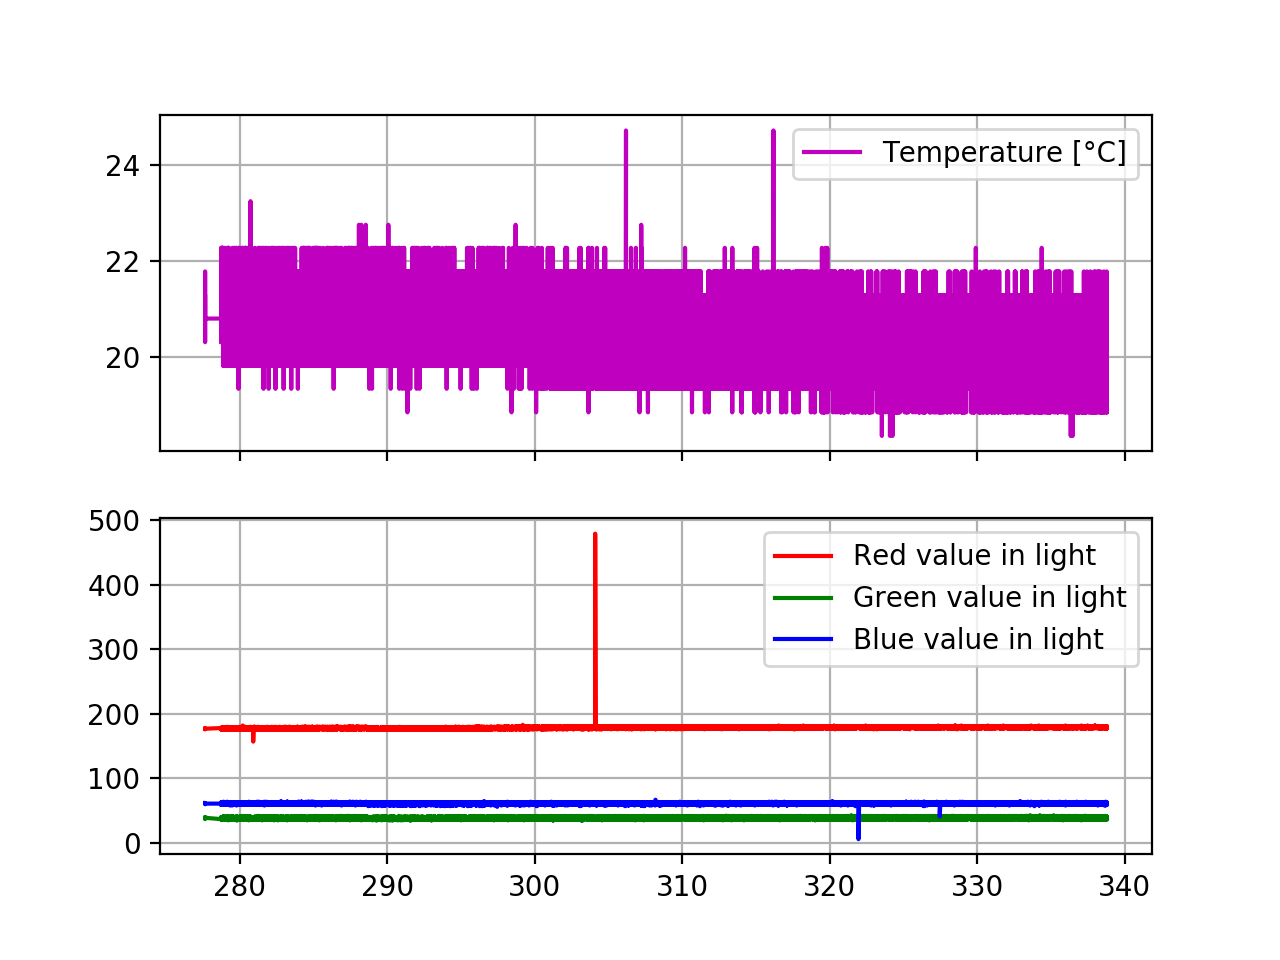

In [11]:
f, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
axes[0].plot(pd_df['timestamp'] / 1000 / 60, pd_df['temperature'], 'm', label='Temperature [°C]')
axes[1].plot(pd_df['timestamp'] / 1000 / 60, pd_df['red'],   'r', label='Red value in light')
axes[1].plot(pd_df['timestamp'] / 1000 / 60, pd_df['green'], 'g', label='Green value in light')
axes[1].plot(pd_df['timestamp'] / 1000 / 60, pd_df['blue'],  'b', label='Blue value in light')
for axis in axes:
    axis.grid()
    axis.legend()

In [12]:
# Stopping Spark Context
sc.stop()